## DCGAN Model

In [2]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dsets
from torch.utils.data import DataLoader


In [3]:
img_size = 28
batch_size = 512

transform_train = transforms.Compose([
	  			transforms.Resize((img_size, img_size)),
          transforms.ToTensor(),
          transforms.Normalize(0.5,0.5)
          ])

# train dataset and loader
train_dataset = dsets.FashionMNIST(train=True, download=True, root = "./", transform = transform_train)
train_loader = DataLoader(train_dataset, batch_size = 512, shuffle = True)

100%|██████████| 26421880/26421880 [00:01<00:00, 16106960.52it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269063.74it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5083424.01it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22680963.23it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Current Device : {}'.format(device))

Current Device : cuda


In [5]:
sample = next(iter(train_loader))
print(sample[0].shape) # img
print(sample[1].shape) # label

torch.Size([512, 1, 28, 28])
torch.Size([512])


### Try to sample out one data point from dataloader

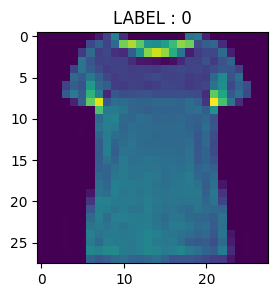

In [6]:
plot_idx = 5
fig = plt.figure(figsize=(3, 3))
plt.imshow(sample[0][plot_idx][0])
plt.title('LABEL : {}'.format(sample[1][plot_idx]))
plt.show()

## Define the DCGAN (Generator + Discriminator)

In [7]:
class Generator(nn.Module):
    def __init__(self, gen_dim_hidden_mul, dim_z, dim_input=28*28):
        super(Generator, self).__init__()
        # define model
        self.model = nn.Sequential(
            nn.ConvTranspose2d(dim_z, gen_dim_hidden_mul * 2, kernel_size=7, stride=1, padding=0, bias=False),  # Output: (128, 14, 14)
            nn.BatchNorm2d(gen_dim_hidden_mul * 2),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(gen_dim_hidden_mul * 2, gen_dim_hidden_mul, kernel_size=4, stride=2, padding=1, bias=False),  # Output: (64, 28, 28)
            nn.BatchNorm2d(gen_dim_hidden_mul),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(gen_dim_hidden_mul, gen_dim_hidden_mul // 2, kernel_size=4, stride=2, padding=1, bias=False),  # Output: (64, 28, 28)
            nn.BatchNorm2d(gen_dim_hidden_mul // 2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(gen_dim_hidden_mul // 2, 1, kernel_size=3,padding=1, bias = False),  # Output: (1, 28, 28)
            nn.Tanh() # tanh because data should be from -1 to 1.
        )

    def forward(self, z):
        batch_size = z.size(0)
        z = z.view(batch_size,-1,1,1)
        out = self.model(z)
        return out

class Discriminator(nn.Module):
    def __init__(self, dis_dim_hidden_mul, dim_input=28*28):
        super(Discriminator, self).__init__()

        # define model
        self.model = nn.Sequential(
            nn.Conv2d(1, dis_dim_hidden_mul // 2, kernel_size=3, stride=1, padding=1, bias=False),  # Output: (64, 28, 28)
            nn.BatchNorm2d(dis_dim_hidden_mul // 2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(dis_dim_hidden_mul // 2, dis_dim_hidden_mul, kernel_size=4, stride=2, padding=1, bias=False),  # Output: (64, 14, 14)
            nn.BatchNorm2d(dis_dim_hidden_mul),
            nn.LeakyReLU(0.1),
            nn.Conv2d(dis_dim_hidden_mul, dis_dim_hidden_mul * 2, kernel_size=4, stride=2, padding=1, bias=False),  # Output: (128, 7, 7)
            nn.BatchNorm2d(dis_dim_hidden_mul * 2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(dis_dim_hidden_mul * 2, dis_dim_hidden_mul * 4, kernel_size=4, stride=2, padding=1, bias=False),  # Output: (128, 7, 7)
            nn.BatchNorm2d(dis_dim_hidden_mul * 4),
            nn.LeakyReLU(0.1),
            nn.Conv2d(dis_dim_hidden_mul * 4, 1, kernel_size = 3, stride=2, padding=0, bias=False),
        )

    def forward(self, x):
        out = self.model(x)
        return torch.sigmoid(out).reshape(-1) # convert to vector of length equal batch_size


### Define Model

In [8]:
gen_dim_hidden_mul = 64
dis_dim_hidden_mul = 64

dim_z = 100
generator = Generator(gen_dim_hidden_mul, dim_z).to(device)
discriminator = Discriminator(dis_dim_hidden_mul).to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr=2e-5, betas=(0.5, 0.999))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.5, 0.999))

print(generator)
print(discriminator)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1)
    (9): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_runn

In [9]:
from torchsummary import summary
summary(generator, (100,))
summary(discriminator,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 128, 7, 7]         627,200
       BatchNorm2d-2            [-1, 128, 7, 7]             256
         LeakyReLU-3            [-1, 128, 7, 7]               0
   ConvTranspose2d-4           [-1, 64, 14, 14]         131,072
       BatchNorm2d-5           [-1, 64, 14, 14]             128
         LeakyReLU-6           [-1, 64, 14, 14]               0
   ConvTranspose2d-7           [-1, 32, 28, 28]          32,768
       BatchNorm2d-8           [-1, 32, 28, 28]              64
         LeakyReLU-9           [-1, 32, 28, 28]               0
           Conv2d-10            [-1, 1, 28, 28]             288
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 791,776
Trainable params: 791,776
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

### Define functions for training and evaluation

In [10]:
def train(generator, discriminator, gen_optimizer, dis_optimizer, sample, dim_z = 100):

    # sample[0]  B by 28 by 28.
    batch_size = sample[0].shape[0] # B

    # -(x log (x') + (1-x) log (1-x')) [x: gt, x': pred.]
    criterion = nn.BCELoss()

    # [1, 1, 1, 1,.... 1]
    real_label = torch.ones(batch_size).to(device)

    # [0, 0, 0, 0,.... 0]
    fake_label = torch.zeros(batch_size).to(device)

    sample_z = torch.randn(batch_size, dim_z).to(device)

    # B by 28**2
    real_img = sample[0].float().to(device)
    fake_img = generator(sample_z)

    # Train Generator
    generator.train()
    gen_optimizer.zero_grad()

    g_loss = criterion(discriminator(fake_img), real_label)

    g_loss.backward()
    gen_optimizer.step()

    # Train Discriminator
    discriminator.train()
    dis_optimizer.zero_grad()

    real_loss = criterion(discriminator(real_img), real_label)
    fake_loss = criterion(discriminator(fake_img.detach()), fake_label)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    dis_optimizer.step()

    return g_loss.item(), d_loss.item()


In [11]:
def test(generator, img_size, dim_z, seed):
    generator.eval()
    with torch.no_grad():
        torch.manual_seed(seed)
        sample_z = torch.randn(1, dim_z).to(device)
        fake_data = generator(sample_z.to(device))

    return 0.5*(fake_data.view(img_size, img_size).detach().cpu().numpy() + 1)

### Run Training

  0%|          | 0/100 [00:00<?, ?it/s]

[EPOCH 0] SAMPLED G LOSS : 1.2428090572357178, SAMPLED D LOSS : 0.3051761984825134


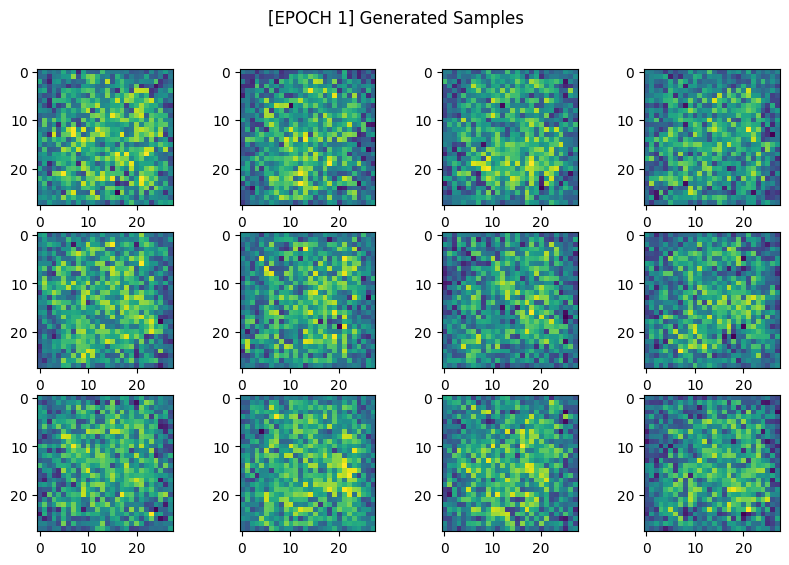

[EPOCH 4] SAMPLED G LOSS : 2.035656690597534, SAMPLED D LOSS : 0.1794688105583191


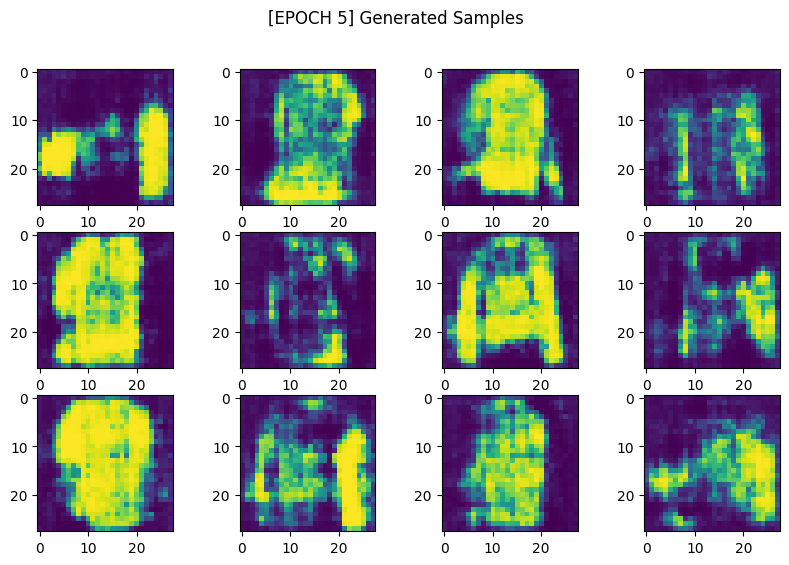

[EPOCH 9] SAMPLED G LOSS : 2.1296558380126953, SAMPLED D LOSS : 0.22028954327106476


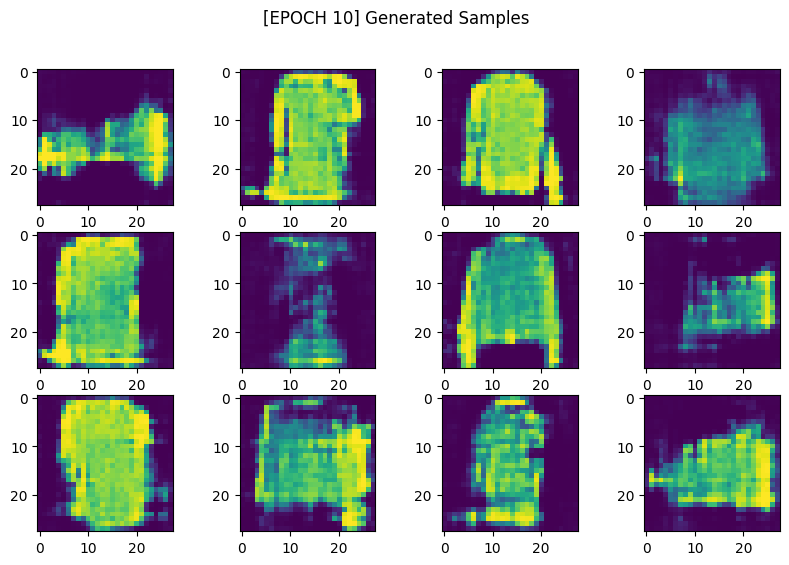

[EPOCH 49] SAMPLED G LOSS : 1.4367923736572266, SAMPLED D LOSS : 0.25239992141723633


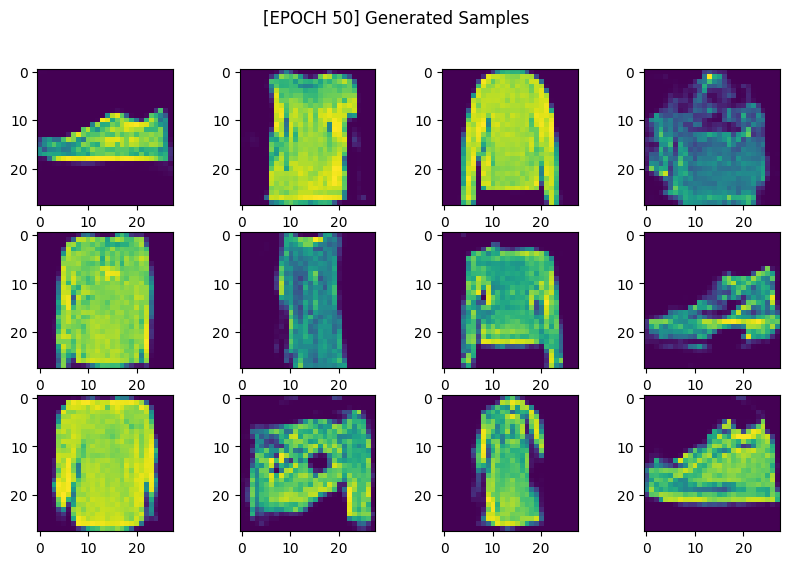

[EPOCH 99] SAMPLED G LOSS : 2.2022407054901123, SAMPLED D LOSS : 0.22574707865715027


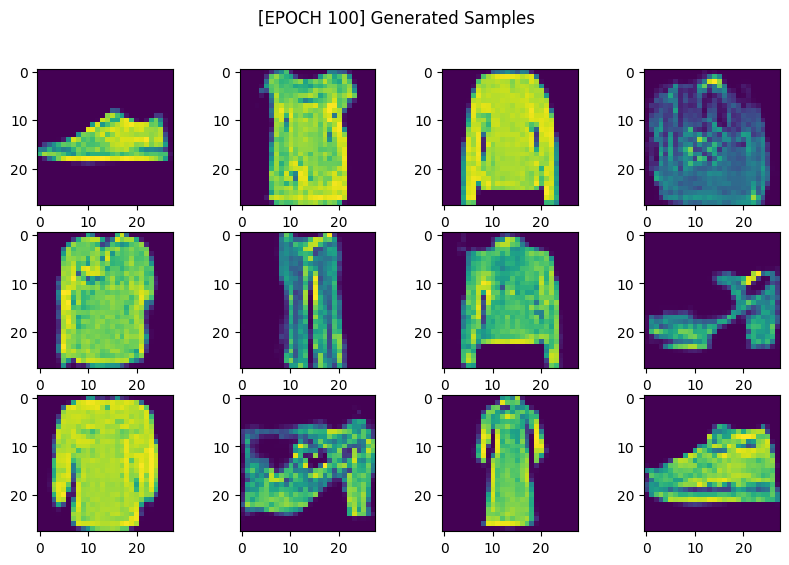

In [12]:
max_epoch = 100
draw_epochs = [1, 5, 10, 50, 100]

gen_epoch_loss_list, dis_epoch_loss_list = [], []

for epoch in tqdm(range(max_epoch)):
    gen_epoch_loss = 0
    dis_epoch_loss = 0
    for idx, sample in enumerate(train_loader):
        g_loss, d_loss = train(generator, discriminator, gen_optimizer, dis_optimizer, sample, dim_z)
        gen_epoch_loss += g_loss
        dis_epoch_loss += d_loss

    gen_epoch_loss /= len(train_loader)
    dis_epoch_loss /= len(train_loader)

    gen_epoch_loss_list.append(gen_epoch_loss)
    dis_epoch_loss_list.append(dis_epoch_loss)

    if (epoch + 1) in draw_epochs:
        print('[EPOCH {}] SAMPLED G LOSS : {}, SAMPLED D LOSS : {}'.format(epoch, g_loss, d_loss))
        fig, axes = plt.subplots(3, 4, figsize=(10, 6))
        idx = 0
        for i in range(3):
          for j in range(4):
            axes[i,j].imshow(test(generator, img_size, dim_z, seed=idx))
            idx += 1
        plt.suptitle('[EPOCH {}] Generated Samples'.format(epoch + 1))
        plt.pause(0.1)



## Draw the Loss Curves

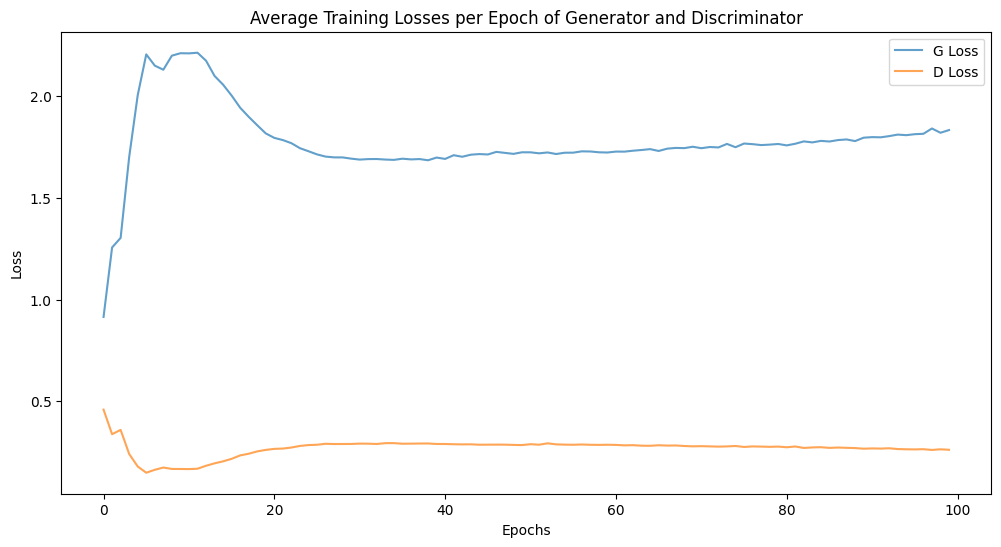

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(gen_epoch_loss_list, label='G Loss', alpha=0.7)
plt.plot(dis_epoch_loss_list, label='D Loss', alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training Losses per Epoch of Generator and Discriminator')
plt.legend()
plt.show()